#1) Setup

In [294]:
# Google-Drive verbinden
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2) Libraries importieren

In [273]:
# Libraries importieren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 3) Daten einlesen

In [274]:
df = pd.read_csv("/content/drive/MyDrive/MyNoteBookFolder/sample_data_100k.csv")

<ipython-input-274-94eb78de8cbf>:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/MyNoteBookFolder/sample_data_100k.csv")


In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100040 entries, 0 to 100039
Data columns (total 67 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               100040 non-null  int64  
 1   vin                      100040 non-null  object 
 2   back_legroom             94722 non-null   object 
 3   bed                      659 non-null     object 
 4   bed_height               14110 non-null   object 
 5   bed_length               14110 non-null   object 
 6   body_type                99607 non-null   object 
 7   cabin                    2058 non-null    object 
 8   city                     100040 non-null  object 
 9   city_fuel_economy        83760 non-null   float64
 10  combine_fuel_economy     0 non-null       float64
 11  daysonmarket             100040 non-null  int64  
 12  dealer_zip               100040 non-null  object 
 13  description              97428 non-null   object 
 14  engi

# 4) Daten bereinigen

Outliers entfernen

In [276]:
# Outlier entfernen mittels Z-Score
z_scores = np.abs((df['price'] - df['price'].mean()) / df['price'].std())
df_no_outliers = df[z_scores < 3]
df_no_outliers[["price", "make_name", "model_name"]].sort_values(by='price', ascending=False)

,price,make_name,model_name
13568,89385.0,Lexus,LS
15225,89340.0,Cadillac,Escalade
93849,89335.0,BMW,8 Series
58467,89330.0,Lincoln,Navigator
86995,89260.0,Audi,A7
...,...,...,...
26436,495.0,Suzuki,Aerio
65933,389.0,Dodge,Grand Caravan
65061,300.0,Honda,Accord
65057,300.0,Chrysler,PT Cruiser


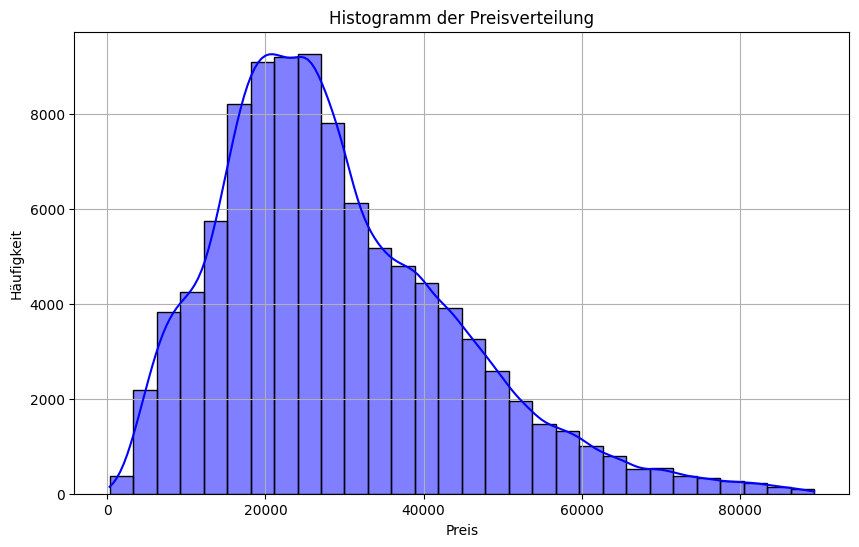

In [277]:
# Histogramm der Preise
plt.figure(figsize=(10, 6))
sns.histplot(df_no_outliers['price'], kde=True, bins=30, color='blue')
plt.title('Histogramm der Preisverteilung')
plt.xlabel('Preis')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.show()

# Relevante Variable extrahieren und Daten umwandeln

In [278]:
df_reduced = df_no_outliers[["body_type", "city_fuel_economy", "engine_type", "fuel_type", "highway_fuel_economy", "horsepower",
                "make_name", "mileage", "model_name", "price", "transmission", "wheel_system_display", "year","listed_date"]]

Null Werte Droppen

In [279]:
df_dropna = df_reduced.dropna()
# Zeilen entfernen, in denen irgendwo '--' vorkommt
df_dropna = df_dropna[~df_dropna.isin(['--']).any(axis=1)]

In [280]:
# Neues Dataframe für nächste Cleaning Schritte
df_clean = df_dropna

Body_Type

In [281]:
# Kategorie "wagon" ausschliessen
df_clean = df_clean[df_clean["body_type"]!="Wagon"]
df_clean["body_type"].value_counts()

body_type
SUV / Crossover    38561
Sedan              20806
Pickup Truck        9770
Minivan             2309
Hatchback           2216
Coupe               1675
Convertible          586
Van                  558
Name: count, dtype: int64

Fluel_Economy

In [282]:
# Neue Spalte mit durchschnittlichem Verbrauch aus city_fuel_economy und highway_fuel_economy
df_clean["average_fuel_economy"] = (df["city_fuel_economy"] + df["highway_fuel_economy"]) / 2
df_clean = df_clean.drop(["city_fuel_economy", "highway_fuel_economy"], axis = 1)

<ipython-input-282-19e675a83fdf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["average_fuel_economy"] = (df["city_fuel_economy"] + df["highway_fuel_economy"]) / 2


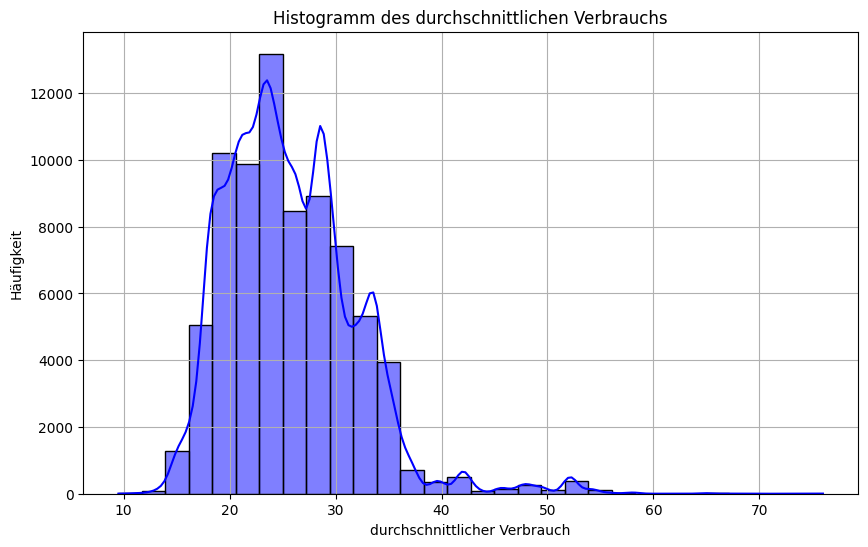

In [283]:
# Histogramm des durchschnittlichen Verbrauchs
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['average_fuel_economy'], kde=True, bins=30, color='blue')
plt.title('Histogramm des durchschnittlichen Verbrauchs')
plt.xlabel('durchschnittlicher Verbrauch')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.show()

Fluel_Type

In [284]:
# Kategorie "Compressed Natural Gas" ausschliessen
df_clean = df_clean[df_clean["fuel_type"]!="Compressed Natural Gas"]
df_clean["fuel_type"].value_counts()

fuel_type
Gasoline             70352
Flex Fuel Vehicle     3482
Hybrid                2127
Diesel                 401
Biodiesel              117
Name: count, dtype: int64

Enigine_type

In [285]:
df_clean["engine_type"] = df_clean["engine_type"].str.replace(' Hybrid', '')
df_clean["engine_type"] = df_clean["engine_type"].str.replace(' Flex Fuel Vehicle', '')
df_clean["engine_type"] = df_clean["engine_type"].str.replace(' Diesel', '')
df_clean["engine_type"] = df_clean["engine_type"].str.replace(' Biodiesel', '')
df_clean["engine_type"].value_counts()

engine_type
I4     41752
V6     22360
V8      8068
H4      1671
I3      1523
I6       904
I5       136
H6        44
V12       10
W12        6
V10        4
R2         1
Name: count, dtype: int64

Transmission

In [286]:
# Umwandeln in eine neue Spalte "Manual": 1=Manuell oder 0=nicht manuell (automatisch)
df_clean["manual"] = df_clean["transmission"].apply(lambda x: 1 if x == "M" else 0)
df_clean[["manual", "transmission"]].loc[df_clean["transmission"]=="A"]
# Spalte "Transmission" löschen
df_clean = df_clean.drop(["transmission"], axis = 1)

Übersicht nochmals anschauen

In [287]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76479 entries, 1 to 100039
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   body_type             76479 non-null  object 
 1   engine_type           76479 non-null  object 
 2   fuel_type             76479 non-null  object 
 3   horsepower            76479 non-null  float64
 4   make_name             76479 non-null  object 
 5   mileage               76479 non-null  float64
 6   model_name            76479 non-null  object 
 7   price                 76479 non-null  float64
 8   wheel_system_display  76479 non-null  object 
 9   year                  76479 non-null  int64  
 10  listed_date           76479 non-null  object 
 11  average_fuel_economy  76479 non-null  float64
 12  manual                76479 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 8.2+ MB


Aus der Variable Year und Listed Date eine neue Variable Age erstellen

1. Year auf des Jahr reduzieren

In [288]:
df_clean["listed_date"].unique()

array(['2020-08-20', '2020-07-29', '2020-06-25', '2020-07-30',
       '2020-08-26', '2020-07-28', '2020-08-13', '2020-09-06',
       '2019-07-10', '2020-08-27', '2020-09-02', '2020-08-16',
       '2020-09-03', '2020-05-31', '2020-07-11', '2020-08-03',
       '2020-09-01', '2020-04-16', '2020-07-31', '2020-07-14',
       '2020-08-09', '2020-08-12', '2020-07-18', '2020-08-23',
       '2020-09-05', '2019-08-07', '2020-02-07', '2020-07-23',
       '2020-09-04', '2020-01-01', '2019-07-27', '2019-11-09',
       '2020-08-29', '2020-08-15', '2020-09-08', '2020-08-02',
       '2020-02-13', '2020-07-04', '2020-07-24', '2020-08-06',
       '2020-06-27', '2020-08-31', '2020-08-08', '2020-09-07',
       '2020-03-18', '2020-07-26', '2020-08-11', '2020-08-14',
       '2020-08-28', '2020-06-20', '2020-06-30', '2020-07-21',
       '2020-08-30', '2020-07-07', '2020-02-08', '2019-09-14',
       '2020-03-11', '2020-07-19', '2020-05-23', '2020-09-09',
       '2020-08-04', '2019-09-28', '2019-08-11', '2019-

In [289]:

# Datumswerte in ein Datumsformat konvertieren
df_clean["listed_date"] = pd.to_datetime(df_clean["listed_date"])

# Jahr extrahieren und als Integer speichern
df_clean["listed_date"] = df_clean["listed_date"].dt.year.astype(int)


variable alter erstellen

In [290]:
df_clean["age"]= df_clean["listed_date"]- df_clean["year"]
del(df_clean["listed_date"])
del(df_clean["year"])

In [291]:
df_clean.head()

,body_type,engine_type,fuel_type,horsepower,make_name,mileage,model_name,price,wheel_system_display,average_fuel_economy,manual,age
1,Sedan,I4,Gasoline,184.0,Chrysler,25794.0,200,13000.0,Front-Wheel Drive,29.5,0,4
3,SUV / Crossover,V6,Gasoline,295.0,Dodge,15732.0,Durango,27300.0,All-Wheel Drive,21.5,0,2
7,SUV / Crossover,I4,Gasoline,138.0,Chevrolet,4580.0,Trax,15724.0,Front-Wheel Drive,29.0,0,2
8,SUV / Crossover,I4,Gasoline,180.0,Jeep,25122.0,Cherokee,21000.0,Four-Wheel Drive,24.0,0,2
11,SUV / Crossover,V6,Gasoline,241.0,Jeep,61161.0,Grand Cherokee,17300.0,Four-Wheel Drive,20.5,0,6


wir löschen variablen raus die bei age -1 haben

In [292]:
df_clean = df_clean.drop(df_clean[df_clean['age'] == -1].index)
df_clean["age"].unique()

array([ 4,  2,  6,  3,  7,  5,  0,  8,  1, 17, 15, 14, 10,  9, 13, 11, 12,
       16, 18, 23, 22, 19, 28, 21, 36, 27, 29, 20, 30, 31, 26, 24, 33, 25,
       35, 34, 32])

# df_clean Exportieren

In [293]:

# Pfad in deinem Google Drive
file_path = '/content/drive/My Drive/df_clean_final.csv'

# DataFrame als CSV speichern
df_clean.to_csv(file_path, index=False)